In [1]:
# Import necessary libraries
import pandas as pd
import datetime
from prophet import Prophet
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

Importing plotly failed. Interactive plots will not work.


In [3]:
# Load the datasets
df_covid = pd.read_csv("/covid_input.csv", delimiter=";")
df_flight = pd.read_csv("/airport_traffic.csv", delimiter=";", encoding='latin1')

/var/folders/g7/_7lrm4c52tv5blzcl14q7p_80000gn/T/ipykernel_12141/81027834.py:2: DtypeWarning: Columns (6,9,14,18,20,22,24,27,28,46,47,48,49,50,51,53,56,57,58,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid = pd.read_csv("/Users/yencao/Downloads/USW Project/Input/covid_input.csv", delimiter=";")


In [4]:
df_covid.head(), df_covid.dtypes

(  iso_code continent     location      date  total_cases  new_cases  \
 0      AFG      Asia  Afghanistan  03.01.20          NaN        0.0   
 1      AFG      Asia  Afghanistan  04.01.20          NaN        0.0   
 2      AFG      Asia  Afghanistan  05.01.20          NaN        0.0   
 3      AFG      Asia  Afghanistan  06.01.20          NaN        0.0   
 4      AFG      Asia  Afghanistan  07.01.20          NaN        0.0   
 
   new_cases_smoothed  total_deaths  new_deaths new_deaths_smoothed  ...  \
 0                NaN           NaN         0.0                 NaN  ...   
 1                NaN           NaN         0.0                 NaN  ...   
 2                NaN           NaN         0.0                 NaN  ...   
 3                NaN           NaN         0.0                 NaN  ...   
 4                NaN           NaN         0.0                 NaN  ...   
 
   male_smokers handwashing_facilities hospital_beds_per_thousand  \
 0          NaN                 37.746 

In [5]:
df_flight.head(), df_flight.dtypes

(   YEAR  MONTH_NUM MONTH_MON  FLT_DATE APT_ICAO       APT_NAME STATE_NAME  \
 0  2016          1       JAN  01.01.16     EBAW        Antwerp    Belgium   
 1  2016          1       JAN  01.01.16     EBBR       Brussels    Belgium   
 2  2016          1       JAN  01.01.16     EBCI      Charleroi    Belgium   
 3  2016          1       JAN  01.01.16     EBLG          Lige    Belgium   
 4  2016          1       JAN  01.01.16     EBOS  Ostend-Bruges    Belgium   
 
    FLT_DEP_1  FLT_ARR_1  FLT_TOT_1  FLT_DEP_IFR_2  FLT_ARR_IFR_2  \
 0          4          3          7            NaN            NaN   
 1        174        171        345          174.0          161.0   
 2         45         47         92           45.0           45.0   
 3          6          7         13            NaN            NaN   
 4          7          7         14            NaN            NaN   
 
    FLT_TOT_IFR_2           Pivot Label  
 0            NaN        Antwerp (EBAW)  
 1          335.0       Brusse

## Analyzing how Covid-19 impacts on number of flights in EU

In [6]:
# Data preprocessing
def preprocess_flight_data(df):
    # Keep essential columns
    df = df[['FLT_DATE', 'STATE_NAME', 'FLT_TOT_1']]
    # Convert date to datetime
    df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'], format='%d.%m.%y')
    #covid_df['date'] = pd.to_datetime(covid_df['date'], format='%d.%m.%y', errors='coerce')
    return df

def preprocess_covid_data(df):
    # Filter countries in EU
    df = df[df['continent'] == 'Europe']
    # Keep essential columns
    df = df[['date', 'location', 'total_cases', 'new_cases', 'people_fully_vaccinated']]
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    return df

df_flight = preprocess_flight_data(df_flight)
df_covid = preprocess_covid_data(df_covid)

/var/folders/g7/_7lrm4c52tv5blzcl14q7p_80000gn/T/ipykernel_12141/4055049873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'], format='%d.%m.%y')
/var/folders/g7/_7lrm4c52tv5blzcl14q7p_80000gn/T/ipykernel_12141/4055049873.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [7]:
# Merge dataframes
def merge_dataframes(flight_df, covid_df):
    merged_df = pd.merge(flight_df, covid_df, how='left', left_on=['FLT_DATE', 'STATE_NAME'], right_on=['date', 'location'])
    merged_df = merged_df.drop(['date', 'location'], axis=1)
    return merged_df

df_final = merge_dataframes(df_flight, df_covid)
df_final.head()

,FLT_DATE,STATE_NAME,FLT_TOT_1,total_cases,new_cases,people_fully_vaccinated
0,2016-01-01,Belgium,7,NaN,NaN,NaN
1,2016-01-01,Belgium,345,NaN,NaN,NaN
2,2016-01-01,Belgium,92,NaN,NaN,NaN
3,2016-01-01,Belgium,13,NaN,NaN,NaN
4,2016-01-01,Belgium,14,NaN,NaN,NaN


In [8]:
# Checke the number of NaN values in each column of the combined dataset
nan_values = df_final.isnull().sum()
nan_values

FLT_DATE                        0
STATE_NAME                      0
FLT_TOT_1                       0
total_cases                464645
new_cases                  454358
people_fully_vaccinated    645932
dtype: int64

In [9]:
# Handle missing values, we fill missing values with O because Covid-19 first appeared in early 2020
df_final['total_cases'] = df_final['total_cases'].fillna(0)
df_final['new_cases'] = df_final['new_cases'].fillna(0)
df_final['people_fully_vaccinated'] = df_final['people_fully_vaccinated'].fillna(0)

In [10]:
# Rename columns
df_final.rename(columns={'FLT_DATE': 'date', 'STATE_NAME': 'country', 'FLT_TOT_1': 'total_flights'}, inplace=True)

In [11]:
# Group the data by 'date' and calculate the sum for each variable
df_final_grouped = df_final.groupby(['date'])[['total_flights', 'total_cases', 'people_fully_vaccinated']].sum()
df_final_grouped

,total_flights,total_cases,people_fully_vaccinated
date,,,
2016-01-01,25341,0.000000e+00,0.000000e+00
2016-01-02,31932,0.000000e+00,0.000000e+00
2016-01-03,36005,0.000000e+00,0.000000e+00
2016-01-04,36018,0.000000e+00,0.000000e+00
2016-01-05,33293,0.000000e+00,0.000000e+00
...,...,...,...
2023-08-27,49422,4.801585e+09,1.278448e+08
2023-08-28,48270,5.042620e+09,1.203796e+09
2023-08-29,50944,4.944651e+09,1.168121e+09


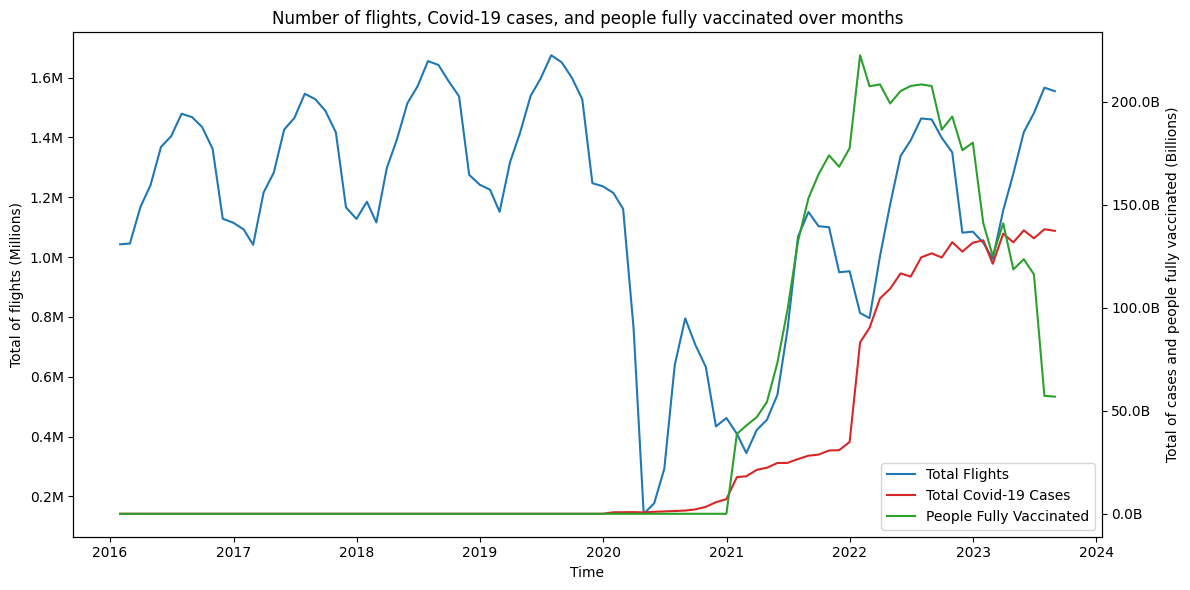

In [12]:
# Define functions for formatting the y-axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return f'{x/1e6:.1f}M'  

def billions(x, pos):
    'The two args are the value and tick position'
    return f'{x/1e9:.1f}B'

# Create a line chart with two y-axes for visualization over the months
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.grid(False)
ax2 = ax1.twinx()
ax2.grid(False)

# Group the data by month and calculate the sum for each variable
df_final_grouped = df_final.resample('M', on='date').sum()

# Plot 'total_flights' on the first y-axis with a blue line
ax1.plot(df_final_grouped.index, df_final_grouped['total_flights'], color='tab:blue', label='Total Flights')
ax1.set_ylabel('Total of flights (Millions)')
ax1.yaxis.set_major_formatter(FuncFormatter(millions))

# Plot 'total_cases' on the second y-axis with a red line
ax2.plot(df_final_grouped.index, df_final_grouped['total_cases'], color='tab:red', label='Total Covid-19 Cases')
ax2.yaxis.set_major_formatter(FuncFormatter(billions))

# Plot 'people_fully_vaccinated' on the second y-axis with a green line
ax2.plot(df_final_grouped.index, df_final_grouped['people_fully_vaccinated'], color='tab:green', label='People Fully Vaccinated')
ax2.set_ylabel('Total of cases and people fully vaccinated (Billions)')
ax2.yaxis.set_major_formatter(FuncFormatter(billions))

# Add labels and a combined legend in the lower right corner
ax1.set_xlabel('Time')
plt.title('Number of flights, Covid-19 cases, and people fully vaccinated over months')

# Combine the legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()  # Ensure all labels fit within the plot
plt.show()


In [13]:
# Calculate the correlation matrix between the numerical columns
correlation_matrix = df_final_grouped[['total_flights', 'total_cases', 'people_fully_vaccinated']].corr()
correlation_matrix

,total_flights,total_cases,people_fully_vaccinated
total_flights,1.000000,0.075458,-0.060558
total_cases,0.075458,1.000000,0.825140
people_fully_vaccinated,-0.060558,0.825140,1.000000


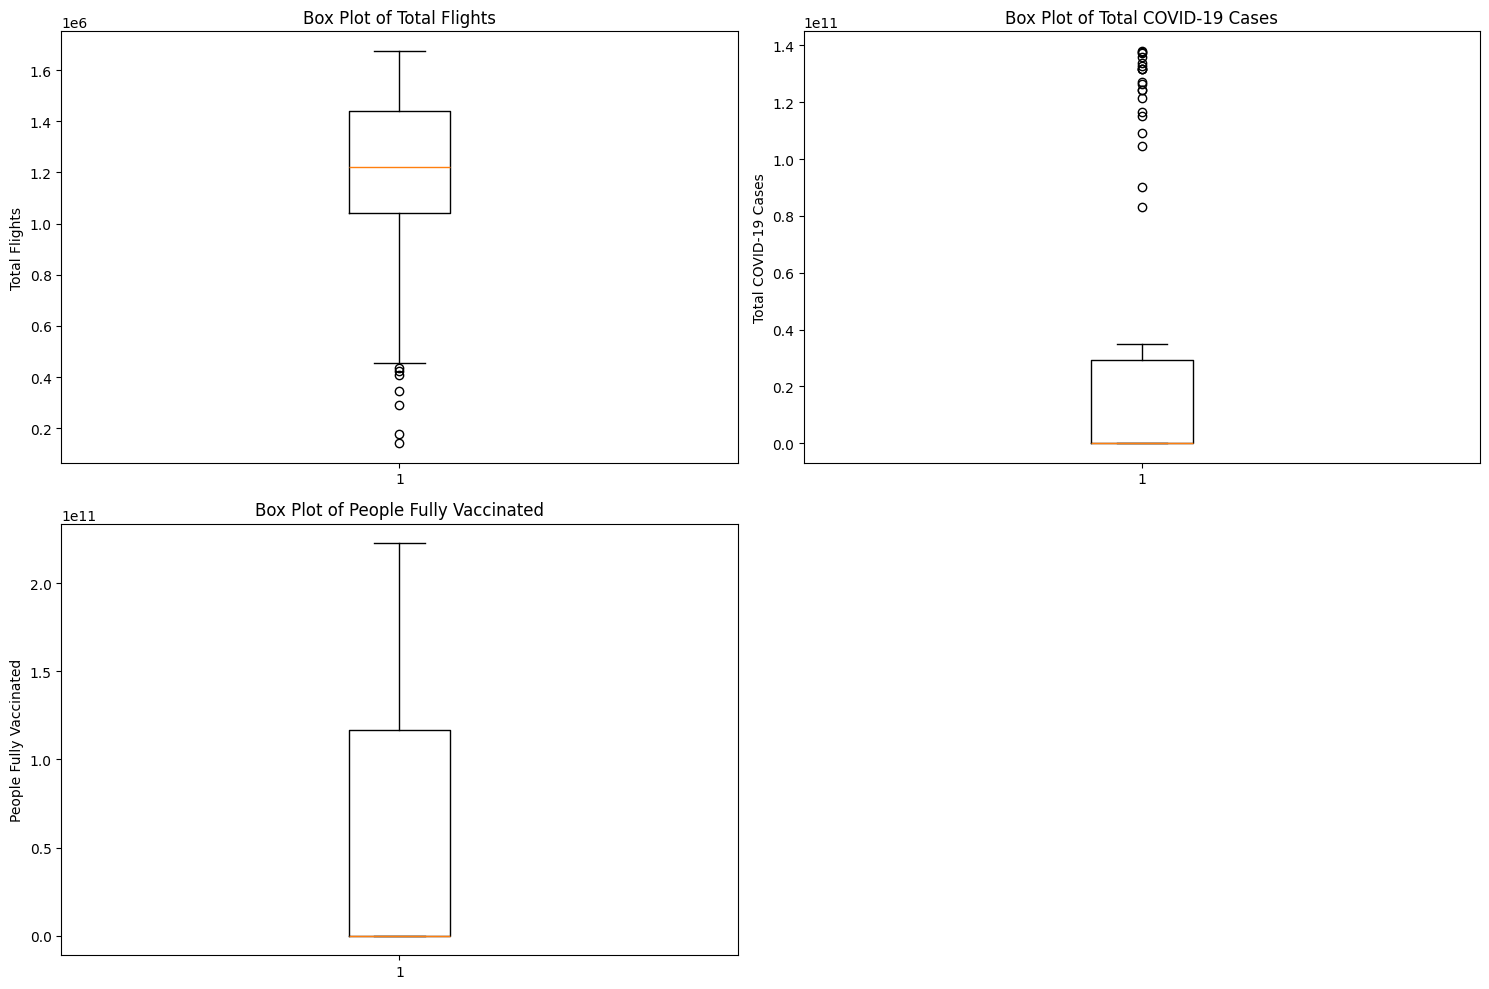

In [14]:
# Plotting box plots for each variable to visually inspect for outliers
plt.figure(figsize=(15,10))

# Total flights
plt.subplot(221)
plt.boxplot(df_final_grouped['total_flights'])
plt.title('Box Plot of Total Flights')
plt.ylabel('Total Flights')

# Total cases
plt.subplot(222)
plt.boxplot(df_final_grouped['total_cases'])
plt.title('Box Plot of Total COVID-19 Cases')
plt.ylabel('Total COVID-19 Cases')

# People fully vaccinated
plt.subplot(223)
plt.boxplot(df_final_grouped['people_fully_vaccinated'])
plt.title('Box Plot of People Fully Vaccinated')
plt.ylabel('People Fully Vaccinated')

plt.tight_layout()
plt.show()

## Predicting number of flights in 365 days in Germany using Facebook's Prophet model

In [15]:
# Filter the data for Germany and sum 'FLT_TOT_1' by date
df_germany = df_flight.loc[df_flight['STATE_NAME'] == 'Germany']
df_germany = df_germany.drop(['STATE_NAME'], axis=1)
df_germany = df_germany.groupby('FLT_DATE')['FLT_TOT_1'].sum().reset_index()
df_germany.rename(columns={'FLT_DATE': 'ds', 'FLT_TOT_1': 'y'}, inplace=True)  # Renaming for Prophet model

In [16]:
df_germany.head()

,ds,y
0,2016-01-01,2976
1,2016-01-02,3689
2,2016-01-03,4213
3,2016-01-04,4512
4,2016-01-05,4290


In [17]:
# Forecast with hyperparameter optimization
def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

In [18]:
# Define the split proportions
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Calculate the split points based on proportions
total_length = len(df_germany)
train_split = int(train_proportion * total_length)
validation_split = train_split + int(validation_proportion * total_length)

# Split the data into training, validation, and testing sets
df_train = df_germany[:train_split]
df_validation = df_germany[train_split:validation_split]
df_test = df_germany[validation_split:]

In [19]:
# Train the model
m = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.add_country_holidays(country_name='DE')
m.fit(df_train)

16:22:45 - cmdstanpy - INFO - Chain [1] start processing
16:22:45 - cmdstanpy - INFO - Chain [1] done processing


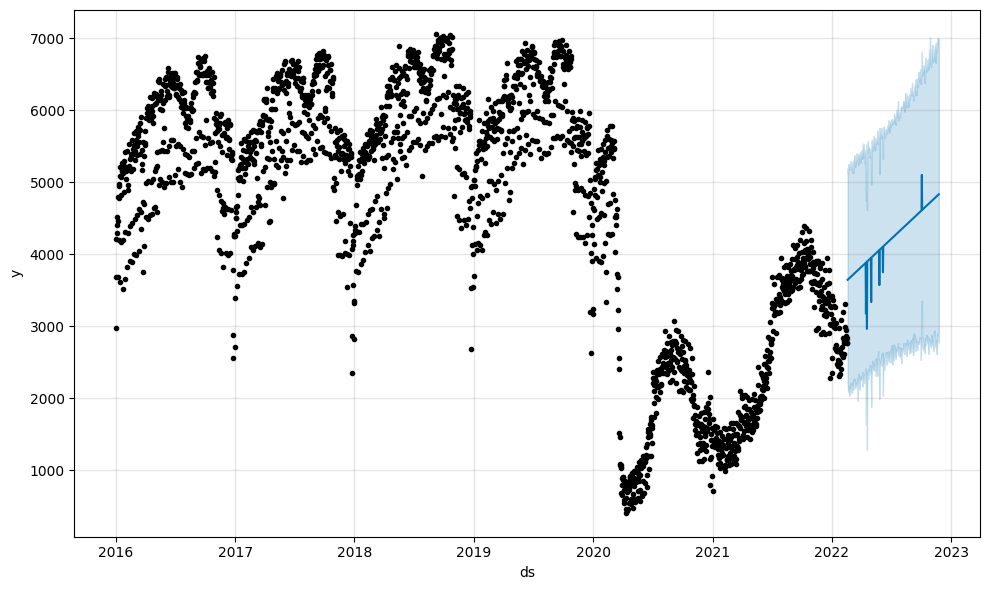

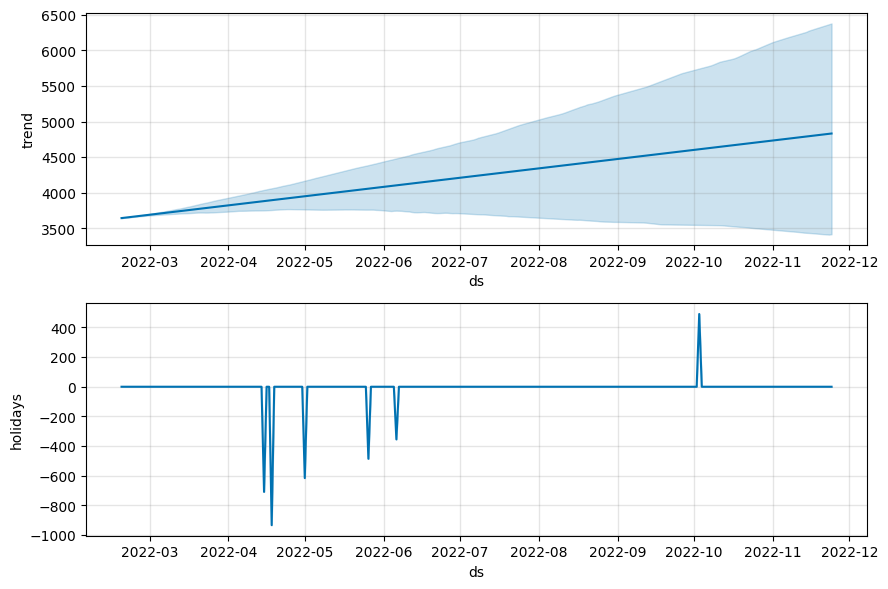

In [20]:
# Plot predicted values for validation dataset
df_predict = m.predict(df_validation)
plot_measure = m.plot(df_predict)
plt_components = m.plot_components(df_predict)

In [21]:
# Predict and evaluate
df_predict_test = m.predict(df_test)
evaluation_results = evaluate(df_test['y'], df_predict_test['yhat'])
print('Evaluation Results:')
for key, value in evaluation_results.items():
    print(f'{key}: {value}')

Evaluation Results:
MAE: 1183.3855577697702
MSE: 1651824.9237492331
RMSE: 1285.2334121665344
R2: -2.04875252919115


In [22]:
# Predict the future with this evaluated model
future_train_model = m.make_future_dataframe(periods=365,freq='D')
forecast_train_model = m.predict(future_train_model)
forecast_train_model.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Christmas Day,...,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2600,2023-02-13,5176.504403,2596.170747,7667.062940,3132.555649,7295.404721,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5176.504403
2601,2023-02-14,5180.759252,2721.811157,7691.557150,3128.795906,7304.558772,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5180.759252
2602,2023-02-15,5185.014101,2541.258915,7650.096382,3125.036164,7313.712823,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5185.014101
2603,2023-02-16,5189.268951,2700.070714,7647.860918,3121.276421,7323.419033,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5189.268951
2604,2023-02-17,5193.523800,2828.824528,7752.346062,3117.516678,7334.320661,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5193.523800


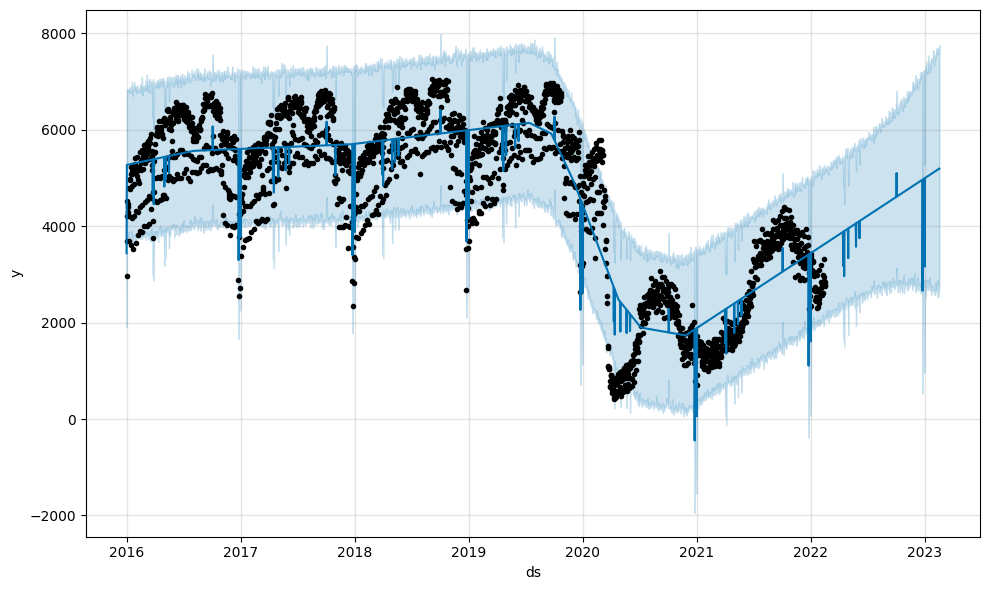

In [23]:
# Plot the forecasted data
plot_forecast = m.plot(forecast_train_model)

## Optimizing model with Optuna framework

In [24]:
# Copy the dataset for tuning
df_train_tune = df_train.copy()
df_validation_tune = df_validation.copy()
df_test_tune = df_test.copy()

In [25]:
# Define a function to find the best hyperparameters using Optuna
def find_params(trial):
    # Generate hyperparameters using the Trial object
    parameters = {
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10)
    }

    # Create and fit a Prophet model with the suggested hyperparameters
    m = Prophet(**parameters, interval_width=0.95, weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.add_country_holidays(country_name='DE')
    m.fit(df_train_tune)

    # Make predictions for the validation dataset and calculate MAE
    validation = m.predict(df_validation_tune)
    mae_for_optuna = mean_absolute_error(df_validation_tune['y'], validation['yhat'])

    # Return the MAE value linked with the Trial object
    return mae_for_optuna

In [26]:
# Create a new study with minimization direction of optimization
study = optuna.create_study(direction='minimize')

# Number of trials
n_trials = 1000

# Perform optimization using a progress bar
for _ in tqdm(range(n_trials), desc="Optimizing"):
    study.optimize(find_params, n_trials=1)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2023-10-13 16:23:22,687] A new study created in memory with name: no-name-3ce52acd-982d-41a6-a4b5-6e8fb4d8090b
Optimizing:   0%| | 0/1000 [00:00<?, ?it16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:23,157] Trial 0 finished with value: 461.90736098765683 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.546051880141357, 'holidays_prior_scale': 1.1153323026644024}. Best is trial 0 with value: 461.90736098765683.
Optimizing:   0%| | 1/1000 [00:00<07:23,16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:23,581] Trial 1 finished with value: 456.8869738763039 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.8624251354893, 'holidays_prior_scale': 2.5101953651868696}. Best is trial 1 with value: 456.8869738763039.
Optimizing:   0%| | 2/1000 [00:00<07:11,16:23:23 - cmdst

[I 2023-10-13 16:23:31,846] Trial 19 finished with value: 468.46818462921533 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.7249274945141921, 'holidays_prior_scale': 7.346830707987934}. Best is trial 12 with value: 427.9514584915398.
Optimizing:   2%| | 20/1000 [00:09<07:1516:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:32,461] Trial 20 finished with value: 437.0567111462166 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.042422020422975, 'holidays_prior_scale': 5.673064114665552}. Best is trial 12 with value: 427.9514584915398.
Optimizing:   2%| | 21/1000 [00:09<08:0516:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:32,890] Trial 21 finished with value: 438.8347138492534 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.202992467018

Optimizing:   4%| | 39/1000 [00:18<07:2816:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:41,259] Trial 39 finished with value: 446.6187548036522 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.343274796325936, 'holidays_prior_scale': 8.078559762047702}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   4%| | 40/1000 [00:18<07:0416:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:41,864] Trial 40 finished with value: 457.03017903629757 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.3588862210470056, 'holidays_prior_scale': 3.2004203138924168}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   4%| | 41/1000 [00:19<07:5116:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10

Optimizing:   6%| | 59/1000 [00:26<06:5316:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:50,110] Trial 59 finished with value: 458.6182133752622 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.022408269828369, 'holidays_prior_scale': 6.51389256764179}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   6%| | 60/1000 [00:27<07:0016:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:50,545] Trial 60 finished with value: 442.228068787165 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.6753163513159512, 'holidays_prior_scale': 4.438831152582628}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   6%| | 61/1000 [00:27<06:5616:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 

Optimizing:   8%| | 79/1000 [00:36<07:0816:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:23:59,712] Trial 79 finished with value: 456.67436735924366 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.97407811355884, 'holidays_prior_scale': 4.918555990087769}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   8%| | 80/1000 [00:36<07:0816:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:00,297] Trial 80 finished with value: 434.4016016846303 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.6293235975067724, 'holidays_prior_scale': 3.2786837654708636}. Best is trial 27 with value: 427.93135437719457.
Optimizing:   8%| | 81/1000 [00:37<07:4116:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-

Optimizing:  10%| | 99/1000 [00:46<07:0916:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:09,211] Trial 99 finished with value: 444.66107080300065 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.6533670741007749, 'holidays_prior_scale': 3.851441834144175}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  10%| | 100/1000 [00:46<06:316:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:09,700] Trial 100 finished with value: 426.496691259934 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.3385700759884296, 'holidays_prior_scale': 3.983923024124496}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  10%| | 101/1000 [00:46<06:516:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:24:17,954] Trial 118 finished with value: 424.13173146418285 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7361025863652885, 'holidays_prior_scale': 5.232216910450959}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  12%| | 119/1000 [00:55<07:016:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:18,380] Trial 119 finished with value: 440.8137709989015 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.7200477960252707, 'holidays_prior_scale': 5.234103168519409}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  12%| | 120/1000 [00:55<06:416:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:18,825] Trial 120 finished with value: 435.63934837534106 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0

Optimizing:  14%|▏| 138/1000 [01:03<06:116:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:26,933] Trial 138 finished with value: 438.1418733289482 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.2504409705503163, 'holidays_prior_scale': 3.337686217059085}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  14%|▏| 139/1000 [01:04<06:216:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:27,428] Trial 139 finished with value: 449.7488691608645 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.074780234293433, 'holidays_prior_scale': 5.4166708733401}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  14%|▏| 140/1000 [01:04<06:316:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
[I 202

Optimizing:  16%|▏| 158/1000 [01:12<05:416:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:35,715] Trial 158 finished with value: 460.5917149804027 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.2592216700637056, 'holidays_prior_scale': 3.24331117255115}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  16%|▏| 159/1000 [01:13<05:416:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:36,170] Trial 159 finished with value: 459.45401134059614 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.679024105702848, 'holidays_prior_scale': 4.010139481215301}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  16%|▏| 160/1000 [01:13<05:516:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:24:44,796] Trial 177 finished with value: 457.6473614370414 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.7941916286029562, 'holidays_prior_scale': 5.311826767636243}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  18%|▏| 178/1000 [01:22<06:316:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:45,195] Trial 178 finished with value: 461.40264655895214 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.6270481516157105, 'holidays_prior_scale': 8.706282554158008}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  18%|▏| 179/1000 [01:22<06:116:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:45,657] Trial 179 finished with value: 445.09304150335186 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_pri

Optimizing:  20%|▏| 197/1000 [01:31<07:016:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:54,320] Trial 197 finished with value: 432.1896644507537 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.4965279539120195, 'holidays_prior_scale': 5.433280028827995}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  20%|▏| 198/1000 [01:31<07:016:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:24:54,714] Trial 198 finished with value: 445.11032933693974 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.699058278236107, 'holidays_prior_scale': 7.641941402450141}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  20%|▏| 199/1000 [01:32<06:316:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
[I 

Optimizing:  22%|▏| 217/1000 [01:40<06:116:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:03,521] Trial 217 finished with value: 424.48887269916 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.8911222388448796, 'holidays_prior_scale': 7.643321179178762}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  22%|▏| 218/1000 [01:40<06:116:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:03,953] Trial 218 finished with value: 463.85628623851005 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.58926810578482, 'holidays_prior_scale': 7.468788630346543}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  22%|▏| 219/1000 [01:41<06:016:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-1

Optimizing:  24%|▏| 237/1000 [01:49<05:416:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:12,732] Trial 237 finished with value: 466.79809213836904 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.911556277983323, 'holidays_prior_scale': 3.855135372484318}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  24%|▏| 238/1000 [01:50<05:316:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:13,106] Trial 238 finished with value: 466.73630700543754 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0973711109473856, 'holidays_prior_scale': 3.4908487788859652}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  24%|▏| 239/1000 [01:50<05:116:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023

Optimizing:  26%|▎| 257/1000 [01:58<05:216:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:21,964] Trial 257 finished with value: 438.0446356260704 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.098275792739289, 'holidays_prior_scale': 4.16449759897135}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  26%|▎| 258/1000 [01:59<06:016:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:22,359] Trial 258 finished with value: 445.33118239695466 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.2919542654447405, 'holidays_prior_scale': 4.740586666536073}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  26%|▎| 259/1000 [01:59<05:416:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2

Optimizing:  28%|▎| 277/1000 [02:08<06:116:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:31,247] Trial 277 finished with value: 461.6654058357152 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.5506386908433822, 'holidays_prior_scale': 3.3699994672406266}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  28%|▎| 278/1000 [02:08<06:016:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:31,756] Trial 278 finished with value: 431.1187955922325 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.132237697423129, 'holidays_prior_scale': 3.8018985684918523}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  28%|▎| 279/1000 [02:09<06:016:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
[I

Optimizing:  30%|▎| 297/1000 [02:17<05:516:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:40,940] Trial 297 finished with value: 428.06187368257395 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.746332441828286, 'holidays_prior_scale': 7.937339126166108}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  30%|▎| 298/1000 [02:18<06:316:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:41,434] Trial 298 finished with value: 453.5130134208339 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.557734000134867, 'holidays_prior_scale': 7.890242432650869}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  30%|▎| 299/1000 [02:18<06:116:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:25:50,127] Trial 316 finished with value: 460.956740385179 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.8707041421754957, 'holidays_prior_scale': 8.030623592722723}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  32%|▎| 317/1000 [02:27<05:216:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:50,653] Trial 317 finished with value: 436.19669872856167 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.890067839031656, 'holidays_prior_scale': 5.912061604783306}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  32%|▎| 318/1000 [02:27<05:316:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:25:51,083] Trial 318 finished with value: 442.5063241688079 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_

Optimizing:  34%|▎| 336/1000 [02:37<05:016:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:00,229] Trial 336 finished with value: 446.98167090545417 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.1929093475906554, 'holidays_prior_scale': 7.200816274871182}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  34%|▎| 337/1000 [02:37<05:016:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:00,754] Trial 337 finished with value: 435.76248886428573 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.927794135473129, 'holidays_prior_scale': 5.491611184020438}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  34%|▎| 338/1000 [02:38<05:116:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-

Optimizing:  36%|▎| 356/1000 [02:46<04:416:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:10,017] Trial 356 finished with value: 464.88051232209335 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.083547730487885, 'holidays_prior_scale': 7.887660054788473}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  36%|▎| 357/1000 [02:47<04:316:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:10,382] Trial 357 finished with value: 455.7739176543053 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.108751219255969, 'holidays_prior_scale': 4.103278799999922}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  36%|▎| 358/1000 [02:47<04:216:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10

Optimizing:  38%|▍| 376/1000 [02:55<04:416:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:18,870] Trial 376 finished with value: 439.09014469428047 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.938185721554759, 'holidays_prior_scale': 5.053339679560985}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  38%|▍| 377/1000 [02:56<04:516:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:19,611] Trial 377 finished with value: 446.6646747895217 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.3507912284538035, 'holidays_prior_scale': 6.034134248182597}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  38%|▍| 378/1000 [02:56<05:416:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-1

Optimizing:  40%|▍| 396/1000 [03:05<04:416:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:28,910] Trial 396 finished with value: 423.94301558977116 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.307721004466483, 'holidays_prior_scale': 3.2250194901481493}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  40%|▍| 397/1000 [03:06<04:416:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:29,355] Trial 397 finished with value: 430.62456890376626 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.335740226633183, 'holidays_prior_scale': 3.194147586047879}. Best is trial 96 with value: 422.34476670198035.
Optimizing:  40%|▍| 398/1000 [03:06<04:316:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done process

[I 2023-10-13 16:26:37,624] Trial 415 finished with value: 453.00832091544896 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.759346751842726, 'holidays_prior_scale': 5.929847482758411}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  42%|▍| 416/1000 [03:14<04:316:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:38,102] Trial 416 finished with value: 450.8653971426074 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.57633646121765, 'holidays_prior_scale': 5.747482983430783}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  42%|▍| 417/1000 [03:15<04:316:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:38,670] Trial 417 finished with value: 425.4850999148355 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_s

Optimizing:  44%|▍| 435/1000 [03:24<04:016:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:47,694] Trial 435 finished with value: 450.3090807858417 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.455172534553, 'holidays_prior_scale': 4.352290781219341}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  44%|▍| 436/1000 [03:24<04:116:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:48,121] Trial 436 finished with value: 454.6399942974187 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.23203295730010215, 'holidays_prior_scale': 1.119560749613806}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  44%|▍| 437/1000 [03:25<04:016:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2023-10-13 16:26:57,506] Trial 454 finished with value: 454.8866037711771 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.421998415364476, 'holidays_prior_scale': 1.973599563597932}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  46%|▍| 455/1000 [03:34<04:016:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:58,015] Trial 455 finished with value: 454.5699464012196 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.6607957556603927, 'holidays_prior_scale': 2.1307412066456903}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  46%|▍| 456/1000 [03:35<04:116:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:26:58,499] Trial 456 finished with value: 456.945041955006 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_

Optimizing:  47%|▍| 474/1000 [03:43<03:416:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:06,513] Trial 474 finished with value: 453.73856251568606 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.5935175762022045, 'holidays_prior_scale': 1.6524803164926891}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  48%|▍| 475/1000 [03:43<03:416:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:06,969] Trial 475 finished with value: 427.3845897542251 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.670367809487953, 'holidays_prior_scale': 1.369759691914818}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  48%|▍| 476/1000 [03:44<03:416:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done process

[I 2023-10-13 16:27:15,533] Trial 493 finished with value: 458.4409479745146 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.234703516645198, 'holidays_prior_scale': 4.363292150438645}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  49%|▍| 494/1000 [03:52<03:416:27:15 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:16,152] Trial 494 finished with value: 436.30059185034594 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.479518129840169, 'holidays_prior_scale': 4.523153855283516}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  50%|▍| 495/1000 [03:53<04:116:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:16,579] Trial 495 finished with value: 452.58274169708363 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior

Optimizing:  51%|▌| 513/1000 [04:01<03:416:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:24,825] Trial 513 finished with value: 427.33120354605705 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.0707712479000255, 'holidays_prior_scale': 4.075261975202259}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  51%|▌| 514/1000 [04:02<04:116:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:25,210] Trial 514 finished with value: 450.7598315819158 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.0885082569804743, 'holidays_prior_scale': 3.0728253685248506}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  52%|▌| 515/1000 [04:02<03:516:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done proces

[I 2023-10-13 16:27:33,713] Trial 532 finished with value: 458.97782232420485 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.935435857811973, 'holidays_prior_scale': 3.1916006594290494}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  53%|▌| 533/1000 [04:10<03:316:27:33 - cmdstanpy - INFO - Chain [1] start processing
16:27:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:34,180] Trial 533 finished with value: 453.3110989566015 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.570445581667028, 'holidays_prior_scale': 8.758136899826276}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  53%|▌| 534/1000 [04:11<03:316:27:34 - cmdstanpy - INFO - Chain [1] start processing
16:27:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:34,580] Trial 534 finished with value: 439.50821733007365 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prio

Optimizing:  55%|▌| 552/1000 [04:19<03:316:27:42 - cmdstanpy - INFO - Chain [1] start processing
16:27:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:43,086] Trial 552 finished with value: 444.9274120075642 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.695584145132058, 'holidays_prior_scale': 2.51291182260434}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  55%|▌| 553/1000 [04:20<03:216:27:43 - cmdstanpy - INFO - Chain [1] start processing
16:27:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:43,482] Trial 553 finished with value: 456.74624692517864 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.410704918293757, 'holidays_prior_scale': 6.490350935275418}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  55%|▌| 554/1000 [04:20<03:116:27:43 - cmdstanpy - INFO - Chain [1] start processing
16:27:43 - cmdstanpy - INFO - Chain [1] done processing

[I 2023-10-13 16:27:52,047] Trial 571 finished with value: 458.8180124977578 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.96995263068595, 'holidays_prior_scale': 1.7267584907865792}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  57%|▌| 572/1000 [04:29<03:216:27:52 - cmdstanpy - INFO - Chain [1] start processing
16:27:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:52,490] Trial 572 finished with value: 447.06917944881144 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.181872787722354, 'holidays_prior_scale': 1.8563491925912563}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  57%|▌| 573/1000 [04:29<03:216:27:52 - cmdstanpy - INFO - Chain [1] start processing
16:27:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:27:52,973] Trial 573 finished with value: 457.6160530465188 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior

Optimizing:  59%|▌| 591/1000 [04:38<03:016:28:00 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:01,286] Trial 591 finished with value: 429.45365690924746 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.183073631786798, 'holidays_prior_scale': 8.484932305785648}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  59%|▌| 592/1000 [04:38<03:016:28:01 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:01,683] Trial 592 finished with value: 462.0392673348809 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.4423243194250464, 'holidays_prior_scale': 8.569621305217586}. Best is trial 406 with value: 421.0878739614649.
Optimizing:  59%|▌| 593/1000 [04:38<02:516:28:01 - cmdstanpy - INFO - Chain [1] start processing
16:28:02 - cmdstanpy - INFO - Chain [1] done processi

[I 2023-10-13 16:28:09,596] Trial 610 finished with value: 462.24784725167075 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.8494725891400092, 'holidays_prior_scale': 9.022740641045898}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  61%|▌| 611/1000 [04:46<02:516:28:09 - cmdstanpy - INFO - Chain [1] start processing
16:28:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:10,054] Trial 611 finished with value: 444.60517807628213 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.5678991446579635, 'holidays_prior_scale': 1.5014403602044715}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  61%|▌| 612/1000 [04:47<02:516:28:10 - cmdstanpy - INFO - Chain [1] start processing
16:28:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:10,483] Trial 612 finished with value: 453.98168320416187 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_p

Optimizing:  63%|▋| 630/1000 [04:55<02:516:28:18 - cmdstanpy - INFO - Chain [1] start processing
16:28:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:18,963] Trial 630 finished with value: 456.3517524632442 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.906210114974387, 'holidays_prior_scale': 2.2411783201703743}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  63%|▋| 631/1000 [04:56<02:416:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:19,379] Trial 631 finished with value: 445.6687040201399 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.185742220788166, 'holidays_prior_scale': 3.346697058118964}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  63%|▋| 632/1000 [04:56<02:416:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:28:27,339] Trial 649 finished with value: 450.0561130948004 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.611618421227607, 'holidays_prior_scale': 6.026794863537828}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  65%|▋| 650/1000 [05:04<02:216:28:27 - cmdstanpy - INFO - Chain [1] start processing
16:28:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:27,846] Trial 650 finished with value: 450.4918184115083 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.273435727247076, 'holidays_prior_scale': 6.286232449142522}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  65%|▋| 651/1000 [05:05<02:316:28:27 - cmdstanpy - INFO - Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:28,257] Trial 651 finished with value: 453.0061443019519 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_s

Optimizing:  67%|▋| 669/1000 [05:13<02:316:28:36 - cmdstanpy - INFO - Chain [1] start processing
16:28:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:36,678] Trial 669 finished with value: 441.77689637329075 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.484899878305376, 'holidays_prior_scale': 2.439408826260175}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  67%|▋| 670/1000 [05:13<02:516:28:36 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:37,132] Trial 670 finished with value: 453.1210979177331 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.900463464761092, 'holidays_prior_scale': 6.888447387231777}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  67%|▋| 671/1000 [05:14<02:416:28:37 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:28:45,468] Trial 688 finished with value: 427.8667223428069 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.414843651178156, 'holidays_prior_scale': 0.6753054313484794}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  69%|▋| 689/1000 [05:22<02:216:28:45 - cmdstanpy - INFO - Chain [1] start processing
16:28:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:45,952] Trial 689 finished with value: 425.29394219691386 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.9487334317160565, 'holidays_prior_scale': 0.37403688360826237}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  69%|▋| 690/1000 [05:23<02:216:28:46 - cmdstanpy - INFO - Chain [1] start processing
16:28:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:46,388] Trial 690 finished with value: 453.7088040146377 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_pr

Optimizing:  71%|▋| 708/1000 [05:32<02:416:28:54 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:55,220] Trial 708 finished with value: 456.4940254608813 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.20095417269213, 'holidays_prior_scale': 0.5470515783211882}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  71%|▋| 709/1000 [05:32<02:216:28:55 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:28:55,629] Trial 709 finished with value: 455.2106914884997 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.2886646226341325, 'holidays_prior_scale': 1.084787412556566}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  71%|▋| 710/1000 [05:32<02:116:28:55 - cmdstanpy - INFO - Chain [1] start processing
16:28:56 - cmdstanpy - INFO - Chain [1] done processin

[I 2023-10-13 16:29:03,939] Trial 727 finished with value: 462.5203594548233 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.47747943810294, 'holidays_prior_scale': 3.4685172396048296}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  73%|▋| 728/1000 [05:41<02:216:29:04 - cmdstanpy - INFO - Chain [1] start processing
16:29:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:04,807] Trial 728 finished with value: 439.31290495135306 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.078143931119692, 'holidays_prior_scale': 8.03799682234632}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  73%|▋| 729/1000 [05:42<02:516:29:04 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:05,267] Trial 729 finished with value: 444.02998061020315 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_

Optimizing:  75%|▋| 747/1000 [05:50<01:516:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:13,370] Trial 747 finished with value: 464.93119176146837 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.016446021224401, 'holidays_prior_scale': 1.9968022766101576}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  75%|▋| 748/1000 [05:50<01:516:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:13,897] Trial 748 finished with value: 445.2379721522766 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.430449080888884, 'holidays_prior_scale': 9.639349677450708}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  75%|▋| 749/1000 [05:51<01:516:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processi

[I 2023-10-13 16:29:22,496] Trial 766 finished with value: 456.5681856790675 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.198025518450145, 'holidays_prior_scale': 8.46559625076112}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  77%|▊| 767/1000 [05:59<01:416:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:22,971] Trial 767 finished with value: 436.6802834118519 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.3698902326370934, 'holidays_prior_scale': 6.233433827664079}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  77%|▊| 768/1000 [06:00<01:416:29:23 - cmdstanpy - INFO - Chain [1] start processing
16:29:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:23,380] Trial 768 finished with value: 454.4824345239729 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_s

Optimizing:  79%|▊| 786/1000 [06:08<01:316:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:31,226] Trial 786 finished with value: 452.33653113779553 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.1106968011147846, 'holidays_prior_scale': 5.106790905854238}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  79%|▊| 787/1000 [06:08<01:316:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:31,730] Trial 787 finished with value: 439.5916489736862 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.29533578222348, 'holidays_prior_scale': 5.56394058885589}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  79%|▊| 788/1000 [06:09<01:316:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing

[I 2023-10-13 16:29:40,424] Trial 805 finished with value: 429.22063267982793 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.170455768746754, 'holidays_prior_scale': 0.755603133710997}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  81%|▊| 806/1000 [06:17<01:316:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:40,849] Trial 806 finished with value: 453.62292416162404 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.9591005068309193, 'holidays_prior_scale': 1.331955690477495}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  81%|▊| 807/1000 [06:18<01:316:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:41,386] Trial 807 finished with value: 445.06724158747085 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_pri

Optimizing:  82%|▊| 825/1000 [06:26<01:216:29:49 - cmdstanpy - INFO - Chain [1] start processing
16:29:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:49,898] Trial 825 finished with value: 452.023454735508 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.819153957206683, 'holidays_prior_scale': 8.058731143228172}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  83%|▊| 826/1000 [06:27<01:216:29:50 - cmdstanpy - INFO - Chain [1] start processing
16:29:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:50,380] Trial 826 finished with value: 455.21683452935605 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.494741095228102, 'holidays_prior_scale': 8.72617553299425}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  83%|▊| 827/1000 [06:27<01:216:29:50 - cmdstanpy - INFO - Chain [1] start processing
16:29:50 - cmdstanpy - INFO - Chain [1] done processing


[I 2023-10-13 16:29:58,420] Trial 844 finished with value: 446.62518368482404 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.419966573429299, 'holidays_prior_scale': 8.4077596760866}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  84%|▊| 845/1000 [06:35<01:116:29:58 - cmdstanpy - INFO - Chain [1] start processing
16:29:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:58,972] Trial 845 finished with value: 439.7770258366354 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.4970524475341302, 'holidays_prior_scale': 0.5360779824291682}. Best is trial 604 with value: 420.9347833932552.
Optimizing:  85%|▊| 846/1000 [06:36<01:116:29:59 - cmdstanpy - INFO - Chain [1] start processing
16:29:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:29:59,409] Trial 846 finished with value: 455.9498802417492 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_

Optimizing:  86%|▊| 864/1000 [06:44<00:516:30:07 - cmdstanpy - INFO - Chain [1] start processing
16:30:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:07,726] Trial 864 finished with value: 433.75084265520076 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.16160500528956, 'holidays_prior_scale': 5.328926689701397}. Best is trial 850 with value: 420.1609896012148.
Optimizing:  86%|▊| 865/1000 [06:45<00:516:30:07 - cmdstanpy - INFO - Chain [1] start processing
16:30:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:08,167] Trial 865 finished with value: 453.88781884120783 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.6948946674863805, 'holidays_prior_scale': 2.5077771503989545}. Best is trial 850 with value: 420.1609896012148.
Optimizing:  87%|▊| 866/1000 [06:45<00:516:30:08 - cmdstanpy - INFO - Chain [1] start processing
16:30:08 - cmdstanpy - INFO - Chain [1] done process

[I 2023-10-13 16:30:16,305] Trial 883 finished with value: 458.27666246727284 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.6451730682947625, 'holidays_prior_scale': 4.270690530206163}. Best is trial 850 with value: 420.1609896012148.
Optimizing:  88%|▉| 884/1000 [06:53<00:516:30:16 - cmdstanpy - INFO - Chain [1] start processing
16:30:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:16,836] Trial 884 finished with value: 424.1158980098247 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.1181542782975393, 'holidays_prior_scale': 1.632651540775666}. Best is trial 850 with value: 420.1609896012148.
Optimizing:  88%|▉| 885/1000 [06:54<00:516:30:16 - cmdstanpy - INFO - Chain [1] start processing
16:30:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:17,287] Trial 885 finished with value: 434.6699078221925 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prio

Optimizing:  90%|▉| 903/1000 [07:02<00:416:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:25,681] Trial 903 finished with value: 454.4716284027077 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.370816772064424, 'holidays_prior_scale': 5.8319468874652625}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  90%|▉| 904/1000 [07:02<00:416:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:26,055] Trial 904 finished with value: 449.7675774120236 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.5807191015923374, 'holidays_prior_scale': 1.579284081673405}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  90%|▉| 905/1000 [07:03<00:416:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processi

[I 2023-10-13 16:30:34,348] Trial 922 finished with value: 441.8685927443031 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.5593301947458666, 'holidays_prior_scale': 9.484712590185605}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  92%|▉| 923/1000 [07:11<00:316:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:34,801] Trial 923 finished with value: 454.5365683906747 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.2291941931282966, 'holidays_prior_scale': 4.693154086436726}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  92%|▉| 924/1000 [07:12<00:316:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:35,332] Trial 924 finished with value: 437.3113128044833 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior

Optimizing:  94%|▉| 942/1000 [07:20<00:216:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:43,857] Trial 942 finished with value: 421.08030459999736 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.199176229541536, 'holidays_prior_scale': 5.563491440126864}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  94%|▉| 943/1000 [07:21<00:216:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:44,210] Trial 943 finished with value: 455.03567964609294 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.0864207871402796, 'holidays_prior_scale': 5.488175250537335}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  94%|▉| 944/1000 [07:21<00:216:30:44 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done process

[I 2023-10-13 16:30:52,728] Trial 961 finished with value: 443.88905648257986 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.449722134861606, 'holidays_prior_scale': 4.996544299426716}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  96%|▉| 962/1000 [07:30<00:116:30:52 - cmdstanpy - INFO - Chain [1] start processing
16:30:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:53,121] Trial 962 finished with value: 450.74874537281096 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.065915266833272, 'holidays_prior_scale': 8.187156459890259}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  96%|▉| 963/1000 [07:30<00:116:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:30:53,520] Trial 963 finished with value: 440.120884672252 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_

Optimizing:  98%|▉| 981/1000 [07:38<00:016:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:31:01,802] Trial 981 finished with value: 453.5536740449008 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.408873819367487, 'holidays_prior_scale': 0.9217281030164273}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  98%|▉| 982/1000 [07:39<00:016:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-10-13 16:31:02,205] Trial 982 finished with value: 447.18751382436744 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.6430946364861385, 'holidays_prior_scale': 2.315037882621946}. Best is trial 897 with value: 419.8502774103111.
Optimizing:  98%|▉| 983/1000 [07:39<00:016:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done process

Best parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.654410794487653, 'holidays_prior_scale': 5.518874885737295}


In [27]:
# Train a new model with the best-found hyperparameters
df_train_tune2 = pd.concat([df_train_tune, df_validation_tune])
m = Prophet(**best_params, interval_width=0.95, weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.add_country_holidays(country_name='DE')
m.fit(df_train_tune2)

16:33:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:34 - cmdstanpy - INFO - Chain [1] done processing


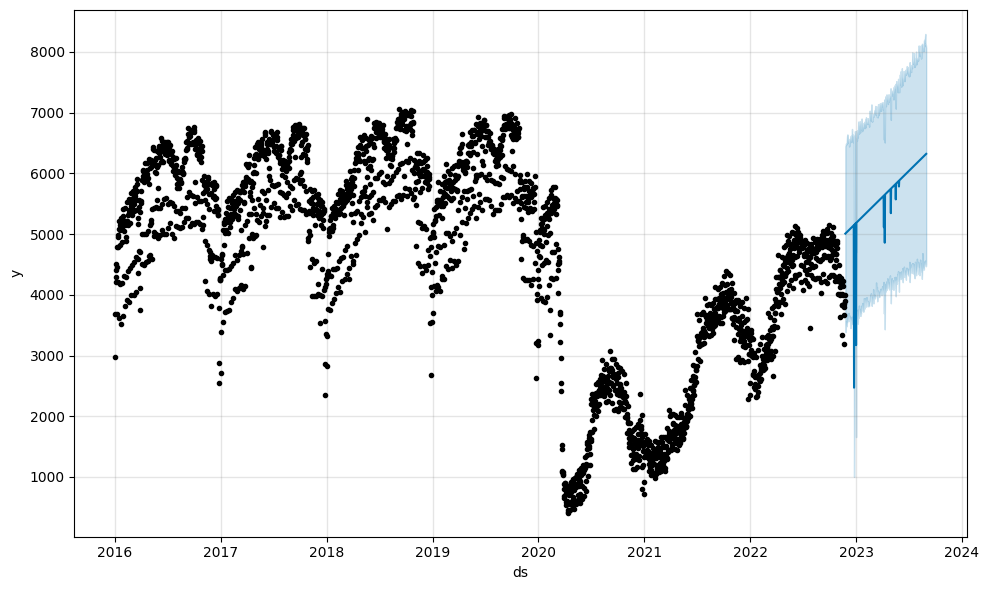

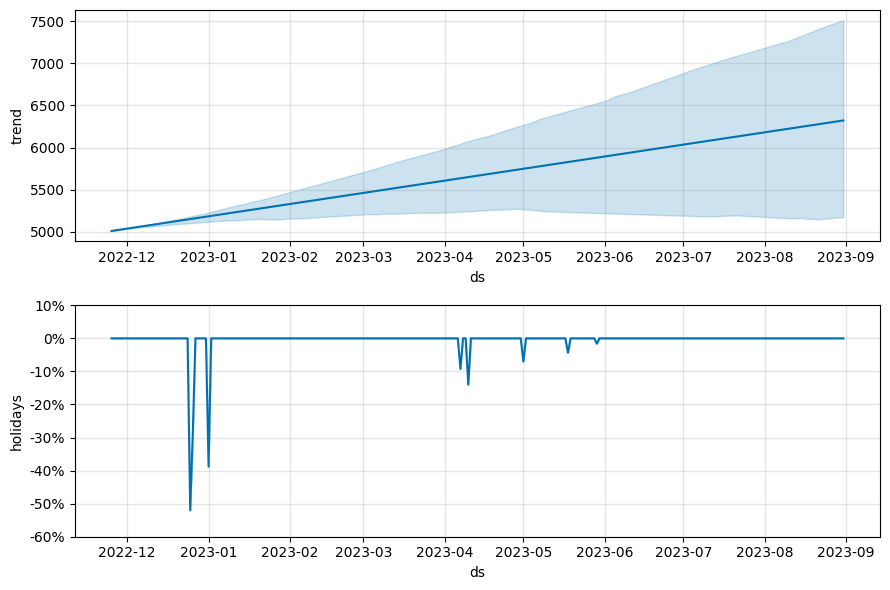

In [28]:
# Make predictions for the test dataset and evaluate the model
df_forecast_tune = m.predict(df_test_tune)
plot_tune = m.plot(df_forecast_tune)
plt_components_tune = m.plot_components(df_forecast_tune)

In [29]:
# Calculate and print evaluation results
evaluation_results_after_tuning = evaluate(df_test_tune['y'], df_forecast_tune['yhat'])
print('Evaluation Results:')
for key, value in evaluation_results_after_tuning.items():
    print(f'{key}: {value}')

Evaluation Results:
MAE: 1419.7987485953631
MSE: 2253021.719984439
RMSE: 1501.0069020442374
R2: -3.1583739101928794
